# Boolean Networks - Computer Practical

Focus: Network dynamics, state spaces, and predictive modeling

## Instructions for Students
- 🟢 **Code**: Code provided - run and observe
- 🟡 **TODO**: You need to complete these - look for TODO comments
- ❓ **Question**: Analysis questions you need to answer


In [7]:
#  Setup and Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

### What are boolean networks?
Boolean networks are mathematical models where:
*   Each node has a binary state: ON (1) or OFF (0)
*   Nodes update based on Boolean rules (AND, OR, NOT)

### Why should you use Boolean Networks?
*   Handle discrete/categorical data naturally  
*   Model complex systems with simple rules
*   Find stable patterns (attractors) in data
*   Test 'what-if' scenarios (perturbation analysis)







---

### Helper functions to create a Boolean network
Run the following code snippet so the basic functions are available.

In [8]:
# 🟢 Helper class to build and simulate boolean network

class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)



---



## Part 1: Simple 3-node Boolean network

Let's first play with a simple 3-node example network

In [9]:
# 🟢 Helper class to build and simulate boolean network

print("Demo: Creating a simple 3-node Boolean network")

demo = BooleanNetwork(['A', 'B', 'C'])

# Add rules with clear descriptions
demo.add_rule('A', lambda state: not state['C'], "A = NOT C")
demo.add_rule('B', lambda state: state['A'] and state['C'], "B = A AND C")
demo.add_rule('C', lambda state: state['A'] or state['B'], "C = A OR B")

print("Rules:")
for node, rule_info in demo.rules.items():
    print(f"  {node}: {rule_info['description']}")

Demo: Creating a simple 3-node Boolean network
Rules:
  A: A = NOT C
  B: B = A AND C
  C: C = A OR B


❓ **Question**: How does the system look like? Draw the directed network structure on paper based on the logical rules!

In [10]:
# 🟢 Test simulation
demo.set_state(A=1, B=0, C=0)
print(f"\nStarting state: A=1, B=0, C=0")

trajectory = demo.simulate(steps=6)
print("Trajectory:")
for i, state in enumerate(trajectory):
    state_dict = {node: state[j] for j, node in enumerate(sorted(demo.nodes.keys()))}
    print(f"  Step {i}: A={state_dict['A']}, B={state_dict['B']}, C={state_dict['C']}")


Starting state: A=1, B=0, C=0
Trajectory:
  Step 0: A=1, B=0, C=0
  Step 1: A=1, B=0, C=1
  Step 2: A=0, B=1, C=1
  Step 3: A=0, B=0, C=1
  Step 4: A=0, B=0, C=0
  Step 5: A=1, B=0, C=0
  Step 6: A=1, B=0, C=1


❓ **Question**: What pattern do you observe?

*   Reaches stable state
*   Oscillates forever <-   
*   Grows exponentially
*   Random behavior




---



## Part 2: Simplified cell regulatory network

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [41]:
#  Create the regulatory network

nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']

def create_regulatory_network(p53_knockout=False, MYC_amplification=True, MDM2_overexpression=False, CDK2_knockout= False):
    """Build the core network and optionally apply mutations."""
    network = BooleanNetwork(nodes)

    # Define Boolean rules (based on real biology, simplified)
    network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
    network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
    network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
    network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
    network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
    network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
    network.add_rule('Growth', lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
    network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

    if p53_knockout:
        network.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)")
    if MYC_amplification:
        network.add_rule('MYC', lambda s: True, "MYC = AMPLIFIED (always ON)")
    if MDM2_overexpression:
        network.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)")
    #if own_mutations:
    if CDK2_knockout:
        network.add_rule('CDK2', lambda s: False, "CDK2 = KNOCKOUT (always OFF)")
        

    return network


network = create_regulatory_network()

print("Rules:")
for node, rule_info in network.rules.items():
    print(f"  {rule_info['description']}")

Rules:
  DNA_damage = INPUT (constant)
  p21 = p53
  MYC = AMPLIFIED (always ON)
  CDK2 = MYC AND (NOT p21) AND (NOT p53)
  MDM2 = MYC
  p53 = DNA_damage AND (NOT MDM2)
  Growth = CDK2 AND MYC AND (NOT p53)
  Death = p53 AND DNA_damage AND (NOT Growth)


❓ **Question**: How does the system look like? Draw the directed network structure on paper based on the logical rules!

For each molecule, add a short description:
- e.g. MYC is suppressed by both p53 and p21
- p21 -> p21 is activated by p53
- CDK2 -> activated by MYC & inhibited by: p21 and p53
- MDM2 -> MDM2 is turned on whenever MYC is on
- p53 -> activated by DNA damage & inhibited by MDM2
- DNA damage -> external input to the system (can be 'ON' or 'OFF')
- Growth -> activated by CDK2 and MYC & inhibited by p53
- Death -> activated by p53 and DNA damage& inhibited by Growth

### Predict the outcomes
❓ **Question**: Before running simulations, make your predictions:

Scenarios:
*   Healthy Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Stressed Cell (Repairable): `{'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0,'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Oncogene Hijacked Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`

For each scenario, decide on the final growth, death and p53 state (0 or 1).



In [12]:
# 🟡 Example code for healthy cell below, adapt to also run Stressed Cell and Oncogene Hijacked Cell scenarios

scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

results = {}

# Run stressed cell scenario
s = "Oncogene Hijacked Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory

final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}

print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")


# TODO: Repeat for other scenarios!

   Reached steady state after 3 steps
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


   Reached steady state after 4 steps
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Reached steady state after 7 steps
   Stressed Cell: Final state: Growth=1, Death=0, p53=0


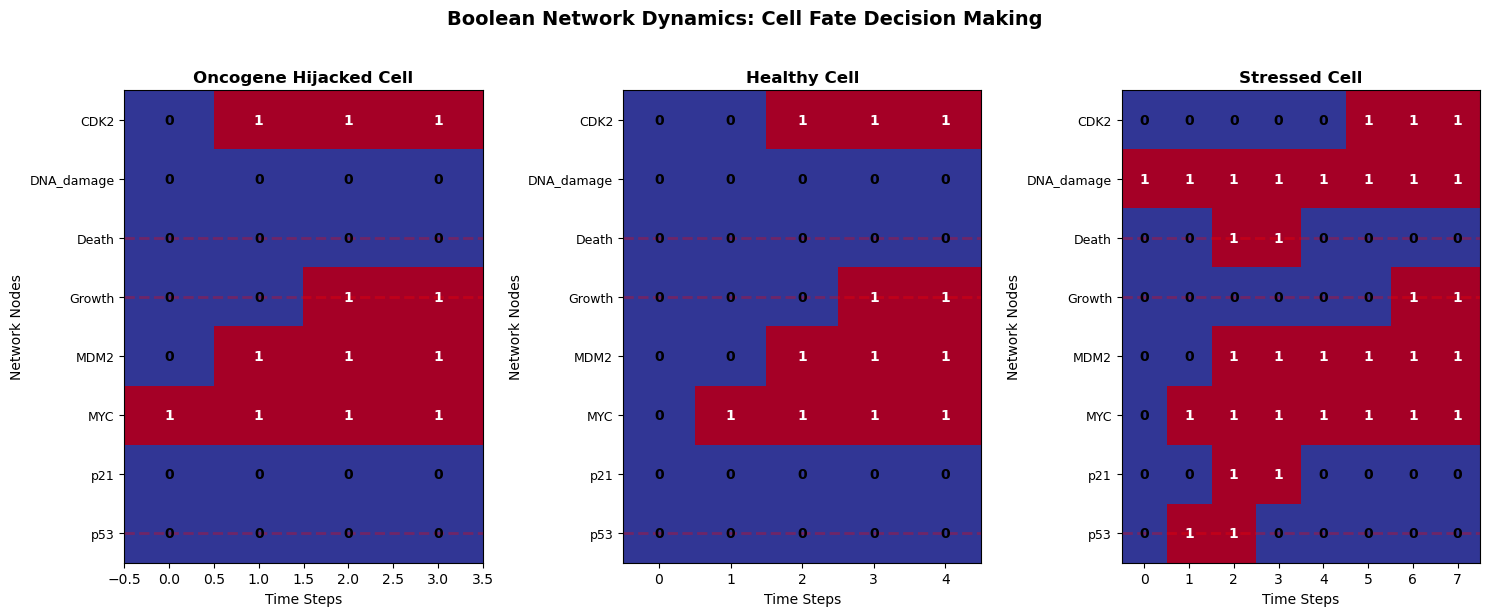

In [13]:
# Plot all three scenarios
for scenario_name, initial_state in scenarios.items():
    if scenario_name not in results:  # Only run if not already in results
        network.set_state(**initial_state)
        trajectory = network.simulate(steps=8)
        results[scenario_name] = trajectory
        
        final_state = trajectory[-1]
        final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
        print(f"   {scenario_name}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Now visualize all results
n_scenarios = len(results)
fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))

if n_scenarios == 1:
    axes = [axes]

for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
    ax = axes[scenario_idx]
    
    # Create heatmap
    trajectory_matrix = trajectory.T  # Transpose for proper orientation
    
    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
    
    # Formatting
    ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)
    
    # Add text annotations
    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                   ha="center", va="center", color=color, fontweight='bold')
    
    # Highlight key output nodes
    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

❓ **Question**: Were your predictions for each scenario correct?
1. Which scenario leads to cell growth?

Hijacked AND Healthy

2. Which scenario leads to cell death?

Stressed

3. How does p53 affect MYC?

Cancer grows with the help of MYC, this is only avoided is p53 acts, which is a growth inhibitor (cancer preventor), if not then cancer wins

4. What happens when there's no DNA damage?

It becomes a healthy cell


---

## **Part 3: Attractor analysis**

Attractors = stable states the network eventually reaches from any starting point

Types:
* Fixed Point: Network stops changing (steady state)
* Limit Cycle: Network oscillates in repeating pattern  

Why is this important?
* Represent system's natural 'destinations'
* Can predict long-term behavior
* Identify stable patterns in system
* Design interventions to reach desired attractors

In [14]:
# 🟡 Let's find the attractor states

attractors = []
max_steps=15
node_names = sorted(network.nodes.keys())
n_nodes = len(node_names)

print(f"Testing all {2**n_nodes} possible initial states...")

# TODO: Generate all possible initial states
# Hint: Use itertools.product([0, 1], repeat=n_nodes)
all_states = list(product([0, 1], repeat=n_nodes))

for initial_state in all_states:
  # Set the network to this initial state
  state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
  network.set_state(**state_dict)

  # TODO: Simulate the network
  trajectory = network.simulate(steps=max_steps, record_history=True)

  # Check if it reached a steady state (last two states are the same)
  if len(trajectory) >= 2:
    final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

  # Check if this is a new attractor
    if np.array_equal(trajectory[-1], trajectory[-2]):  # Steady state reached
      if final_state not in attractors:
        attractors.append(final_state)

Testing all 256 possible initial states...
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reac

❓ **Questions and interpretation**
1. How many total states did we test?

256

2. Why does the number of states grow so quickly?

Each node can be either 0 or 1 (2 possible states per node). With 8 nodes, we have 2^8 = 256 total possible combinations.

3. What would happen if we had 15 nodes instead of 8?

We would have 2^15 = 32,768 possible states.

---


FOUND 2 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → 

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → 


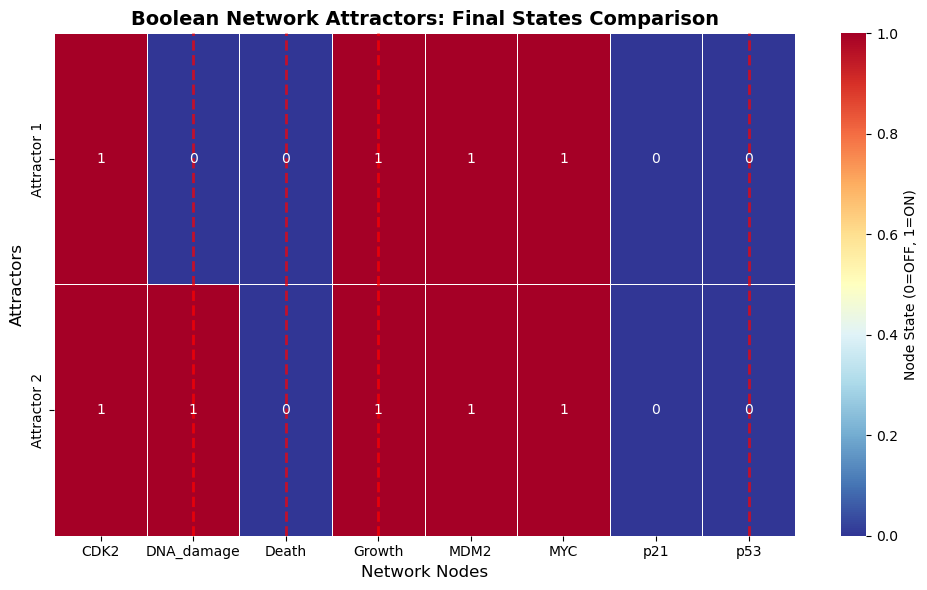

In [15]:
# 🟡 Let's find the attractor states

print(f"\nFOUND {len(attractors)} ATTRACTORS:")

for i, attractor in enumerate(attractors):
        print(f"\nAttractor {i+1}: {list(attractor)}")

        # Create state dictionary for easy access
        state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

        # Analyze the biological meaning
        growth_active = state_dict['Growth'] == 1
        death_active = state_dict['Death'] == 1
        p53_active = state_dict['p53'] == 1
        dna_damage_active = state_dict['DNA_damage'] == 1


        print(f"   Growth: {'ON' if growth_active else 'OFF'}")
        print(f"   Death: {'ON' if death_active else 'OFF'}")
        print(f"   p53: {'ON' if p53_active else 'OFF'}")
        print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

        # TODO: Interpret the meaning
        if growth_active and not death_active and not dna_damage_active:
            interpretation = ""
        elif death_active and not growth_active:
            interpretation = ""
        elif growth_active and not death_active and dna_damage_active:
            interpretation = ""
        else:
            interpretation = "CONFLICT - Unusual state"

        print(f"   → {interpretation}")


# Convert attractors to clean matrix
attractor_matrix = []
for attractor in attractors:
    clean_row = [int(x) for x in attractor]
    attractor_matrix.append(clean_row)

attractor_matrix = np.array(attractor_matrix)

# Create heatmap
plt.figure(figsize=(10, max(6, len(attractors))))

# Create heatmap with custom colors
ax = sns.heatmap(attractor_matrix,
                 xticklabels=node_names,
                 yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                 cmap='RdYlBu_r',
                 cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                 annot=True,
                 fmt='d',
                 linewidths=0.5)

plt.title('Boolean Network Attractors: Final States Comparison',
          fontsize=14, fontweight='bold')
plt.xlabel('Network Nodes', fontsize=12)
plt.ylabel('Attractors', fontsize=12)

# Highlight key output nodes
output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
for node in output_nodes:
    if node in node_names:
        idx = node_names.index(node)
        ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.show()

❓ **Questions and interpretation**
1. How many attractors did we find? 3
2. What does each attractor represent biologically?
- Attractor 1: **Cancerous growth state** (Growth=ON, Death=OFF, p53=OFF, DNA_damage=OFF) - cell is growing healthily
- Attractor 2: **Protective death state** (Growth=OFF, Death=ON, p53=ON, DNA_damage=ON) - cells sacrifice themselves when damaged  
- Attractor 3: **Oncogene hijacked state** (Growth=ON, Death=OFF, p53=OFF, DNA_damage=ON) - uncontrolled growth with damage
3. Which attractor represents a 'healthy' cell state and which one a cancerous' cell state?
- **Healthy state**: attraactor 1



---





Analyzing 256 initial states...
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 3 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady state after 5 steps
   Reached steady state after 4 steps
   Reached steady 

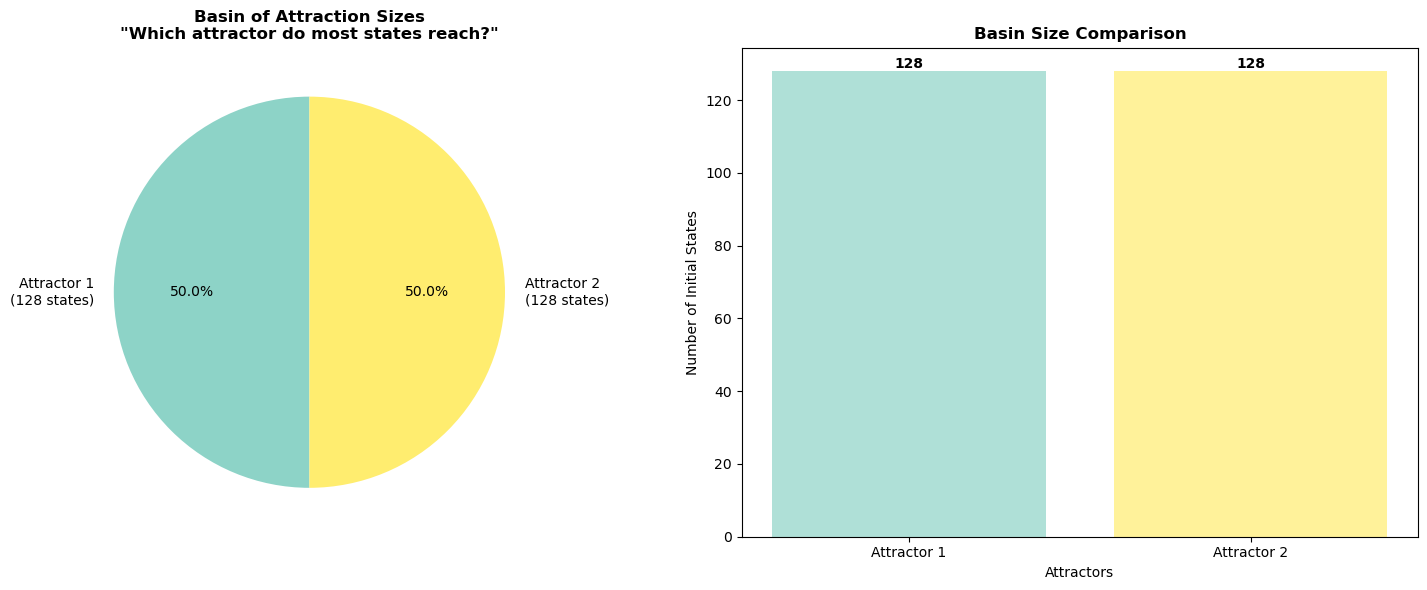

In [16]:
# 🟡 Which states end up in which attractor?

# Track which initial states lead to which attractors
basin_data = defaultdict(list)  # attractor -> list of initial states
attractor_map = {}  # initial_state -> attractor_index

n_nodes = len(node_names)
all_states = list(product([0, 1], repeat=n_nodes))
print(f"Analyzing {len(all_states)} initial states...")

for initial_state in all_states:
    # Set network state
    state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
    network.set_state(**state_dict)

    # Simulate
    trajectory = network.simulate(steps=max_steps, record_history=True)

    # Find which attractor this leads to
    if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
        final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

        # Find matching attractor
        for att_idx, attractor in enumerate(attractors):
            clean_attractor = tuple(int(x) for x in attractor)
            if final_state == clean_attractor:
                basin_data[att_idx].append(initial_state)
                attractor_map[initial_state] = att_idx
                break

# Display basin sizes
print(f"\n Basin Sizes:")
total_states = len(all_states)
for att_idx in range(len(attractors)):
    basin_size = len(basin_data[att_idx])
    percentage = (basin_size / total_states) * 100
    print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

# Create pie chart of basin sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of basin sizes
basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))

wedges, texts, autotexts = ax1.pie(basin_sizes,
                                   labels=basin_labels,
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   startangle=90)

ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"',
              fontsize=12, fontweight='bold')

# Bar chart comparison
attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)

ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Initial States', fontsize=10)
ax2.set_xlabel('Attractors', fontsize=10)

# Add value labels on bars
for bar, size in zip(bars, basin_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

❓ **Questions and interpretation**
* How many initial states lead to each attractor?
+ 128
120
8 
* Which attractors are most "popular" (large basins)?
+ attarctor 1 - the healthy one

---



# Assignement 3

Scenario analysis function:

In [17]:
def scenario_analysis(network, graph_title, gene):
    mutant_results = {}
    mutant_node_names = sorted(network.nodes.keys())

    for scenario_name, initial_state in scenarios.items():
        network.set_state(**initial_state)
        with redirect_stdout(io.StringIO()):
            trajectory = network.simulate(steps=8)
        mutant_results[scenario_name] = trajectory

        final_state = trajectory[-1]
        final_dict = {node: int(final_state[i]) for i, node in enumerate(mutant_node_names)}
        print(f"  {scenario_name}: Growth={final_dict['Growth']}, Death={final_dict['Death']}, {gene }={final_dict[gene]}")

    n_scenarios = len(mutant_results)
    fig, axes = plt.subplots(1, n_scenarios, figsize=(5 * n_scenarios, 6))

    if n_scenarios == 1:
        axes = [axes]

    for scenario_idx, (scenario_name, trajectory) in enumerate(mutant_results.items()):
        ax = axes[scenario_idx]
        trajectory_matrix = trajectory.T

        ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
        ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
        ax.set_xlabel('Time Steps', fontsize=10)
        ax.set_ylabel('Network Nodes', fontsize=10)
        ax.set_yticks(range(len(mutant_node_names)))
        ax.set_yticklabels(mutant_node_names, fontsize=9)

        for t in range(trajectory.shape[0]):
            for n in range(len(mutant_node_names)):
                color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
                ax.text(t, n, int(trajectory_matrix[n, t]), ha='center', va='center', color=color, fontweight='bold')

        output_indices = [i for i, name in enumerate(mutant_node_names) if name in ['Growth', 'Death', gene]]
        for output_idx in output_indices:
            ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

    plt.suptitle(f'{graph_title} - Scenario Dynamics', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

Attractor search function:

In [18]:
def attractor_search(network, graph_title, gene):
    mutant_attractors = []
    mutant_attractor_info = []
    mutant_max_steps = 15
    mutant_node_names = sorted(network.nodes.keys())
    mutant_all_states = list(product([0, 1], repeat=len(mutant_node_names)))

    print(f'Testing all {len(mutant_all_states)} possible initial states under Mutation of {gene}' )

    for initial_state in mutant_all_states:
        state_dict = {mutant_node_names[i]: initial_state[i] for i in range(len(mutant_node_names))}
        network.set_state(**state_dict)

        with redirect_stdout(io.StringIO()):
            trajectory = network.simulate(steps=mutant_max_steps, record_history=True)

        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(int(x) for x in trajectory[-1])
            if final_state not in mutant_attractors:
                mutant_attractors.append(final_state)

    if not mutant_attractors:
        print('No attractors found for the mutated network.')
    else:
        for idx, attractor in enumerate(mutant_attractors, start=1):
            state_dict = {mutant_node_names[j]: int(attractor[j]) for j in range(len(mutant_node_names))}
            growth_active = state_dict['Growth'] == 1
            death_active = state_dict['Death'] == 1
            gene_active = state_dict[gene] == 1
            dna_damage_active = state_dict['DNA_damage'] == 1

            if growth_active and not death_active:
                if dna_damage_active:
                    interpretation = 'Cancer-like growth despite DNA damage'
                else:
                    interpretation = 'Cancer-like growth in healthy conditions'
            elif death_active and not growth_active:
                interpretation = 'Cell death / apoptosis'
            else:
                interpretation = 'Quiescent or unresolved state'

            mutant_attractor_info.append({
                'state': attractor,
                'interpretation': interpretation,
                'cancer_like': growth_active and not death_active
            })

            print()
            print(f"Attractor {idx}: {list(attractor)}")
            print(f"   Growth: {'ON' if growth_active else 'OFF'} | Death: {'ON' if death_active else 'OFF'} | {gene}: {'ON' if gene_active else 'OFF'} | DNA Damage: {'ON' if dna_damage_active else 'OFF'}")
            print(f"   Interpretation: {interpretation}")

        mutant_attractor_matrix = np.array([list(map(int, att)) for att in mutant_attractors])

        plt.figure(figsize=(10, max(6, len(mutant_attractors))))
        ax = sns.heatmap(
            mutant_attractor_matrix,
            xticklabels=mutant_node_names,
            yticklabels=[f'Attractor {i+1}' for i in range(len(mutant_attractors))],
            cmap='RdYlBu_r',
            cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
            annot=True,
            fmt='d',
            linewidths=0.5,
        )

        plt.title(f'{graph_title} - Attractors', fontsize=14, fontweight='bold')
        plt.xlabel('Network Nodes', fontsize=12)
        plt.ylabel('Attractors', fontsize=12)

        for node in ['Growth', 'Death', gene, 'DNA_damage']:
            if node in mutant_node_names:
                idx = mutant_node_names.index(node)
                ax.axvline(x=idx + 0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

        plt.tight_layout()
        plt.show()
        return mutant_attractors, mutant_attractor_info

Basin analysis function:

In [19]:
def basin_analysis(network, graph_title, mutant_attractors, mutant_attractor_info):
    mutant_max_steps = 15
    mutant_node_names = sorted(network.nodes.keys())
    mutant_all_states = list(product([0, 1], repeat=len(mutant_node_names)))

    if mutant_attractors:
        mutant_basin_data = defaultdict(list)
        mutant_attractor_map = {}
        total_states = len(mutant_all_states)

        for initial_state in mutant_all_states:
            state_dict = {mutant_node_names[i]: initial_state[i] for i in range(len(mutant_node_names))}
            network.set_state(**state_dict)

            with redirect_stdout(io.StringIO()):
                trajectory = network.simulate(steps=mutant_max_steps, record_history=True)

            if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
                final_state = tuple(int(x) for x in trajectory[-1])
                for att_idx, attractor in enumerate(mutant_attractors):
                    if final_state == tuple(int(x) for x in attractor):
                        mutant_basin_data[att_idx].append(initial_state)
                        mutant_attractor_map[initial_state] = att_idx
                        break

        print()
        print(f'Basin sizes under{graph_title}:')
        cancer_like_states = 0
        for att_idx, info in enumerate(mutant_attractor_info):
            basin_size = len(mutant_basin_data[att_idx])
            percentage = (basin_size / total_states) * 100
            print(f"  Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%) -> {info['interpretation']}")
            if info['cancer_like']:
                cancer_like_states += basin_size

        cancer_like_pct = (cancer_like_states / total_states) * 100
        print()
        print(f"Overall, {cancer_like_states} of {total_states} states ({cancer_like_pct:5.1f}%) flow into cancer-like attractors when p53 is knocked out.")

        basin_sizes = [len(mutant_basin_data[i]) for i in range(len(mutant_attractors))]
        basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
        colors = plt.cm.Set3(np.linspace(0, 1, len(mutant_attractors)))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.pie(basin_sizes, labels=basin_labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title(f'{graph_title} - Basin of Attraction Sizes', fontsize=12, fontweight='bold')

        bars = ax2.bar([f'Attractor {i+1}' for i in range(len(mutant_attractors))], basin_sizes, color=colors, alpha=0.7)
        ax2.set_title(f'{graph_title} - Basin Size Comparison', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Number of Initial States', fontsize=10)
        ax2.set_xlabel('Attractors', fontsize=10)

        for bar, size in zip(bars, basin_sizes):
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{size}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()
    else:
        print('Skipping basin analysis because no attractors were found.')


## Mutation A: p53 Knockout (Loss of Tumor Suppressor)

We now mutate the Boolean network by forcing `p53` OFF. This mimics a loss-of-function mutation frequently observed in cancers and lets us explore how robust the decision circuit is to losing this tumour suppressor.

In [20]:
#  Apply Mutation
p53_mutant = create_regulatory_network(p53_knockout=True) 
print(f"{p53_mutant.rules['p53']['description']}")



p53 = BROKEN (always OFF)


### Scenario Analysis Under Mutation A

Reuse the three practical scenarios to check how the fate decision changes when `p53` is permanently OFF.

  Healthy Cell: Growth=1, Death=0, p53=0
  Stressed Cell: Growth=1, Death=0, p53=0
  Oncogene Hijacked Cell: Growth=1, Death=0, p53=0


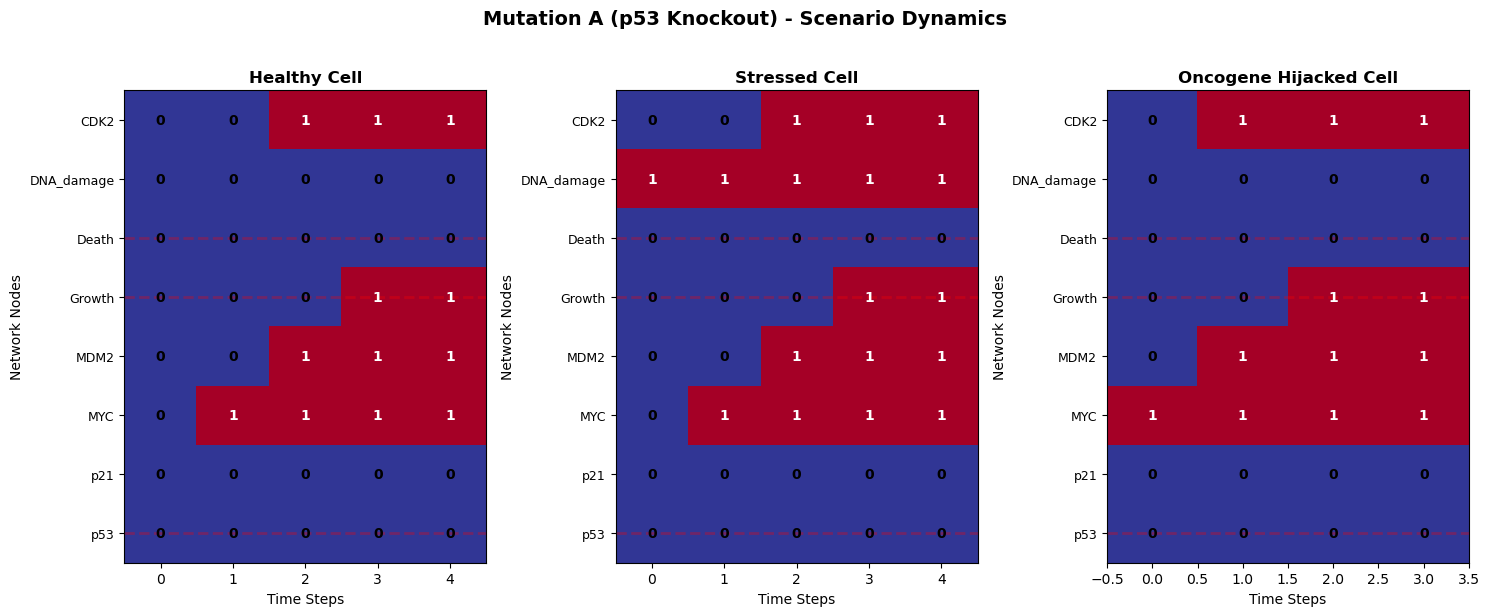

In [21]:
graph_title_a = 'Mutation A (p53 Knockout)'
scenario_analysis(p53_mutant, graph_title_a, 'p53')

### Attractor Analysis for Mutation A

Scan the full state space to see which steady states remain reachable and how often the network falls into cancer-like behaviour.

Testing all 256 possible initial states under Mutation of p53

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | p53: OFF | DNA Damage: OFF
   Interpretation: Cancer-like growth in healthy conditions

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | p53: OFF | DNA Damage: ON
   Interpretation: Cancer-like growth despite DNA damage


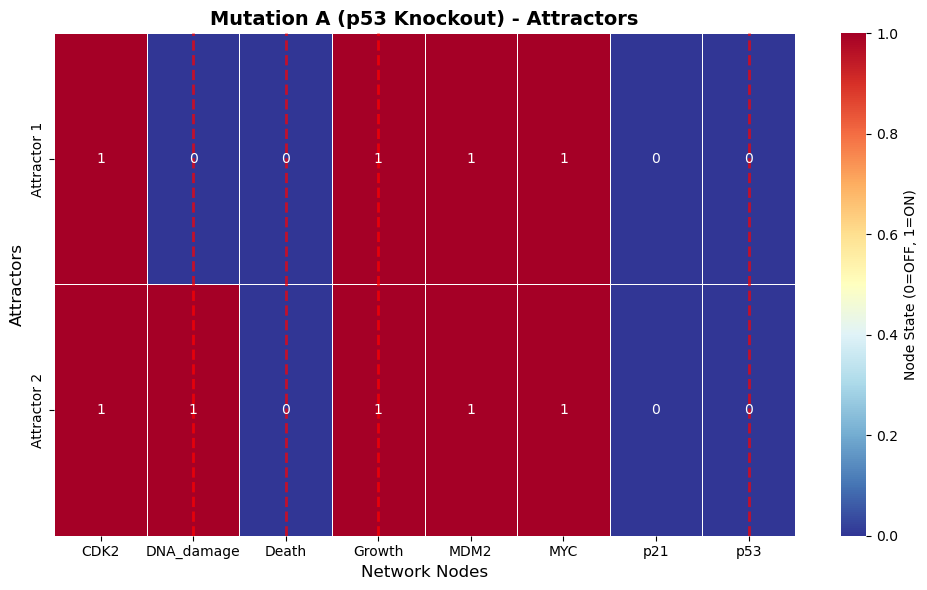

In [22]:
mutant_attractors, mutant_attractor_info = attractor_search(p53_mutant, graph_title_a, 'p53')


Basin sizes underMutation A (p53 Knockout):
  Attractor 1: 128 states ( 50.0%) -> Cancer-like growth in healthy conditions
  Attractor 2: 128 states ( 50.0%) -> Cancer-like growth despite DNA damage

Overall, 256 of 256 states (100.0%) flow into cancer-like attractors when p53 is knocked out.


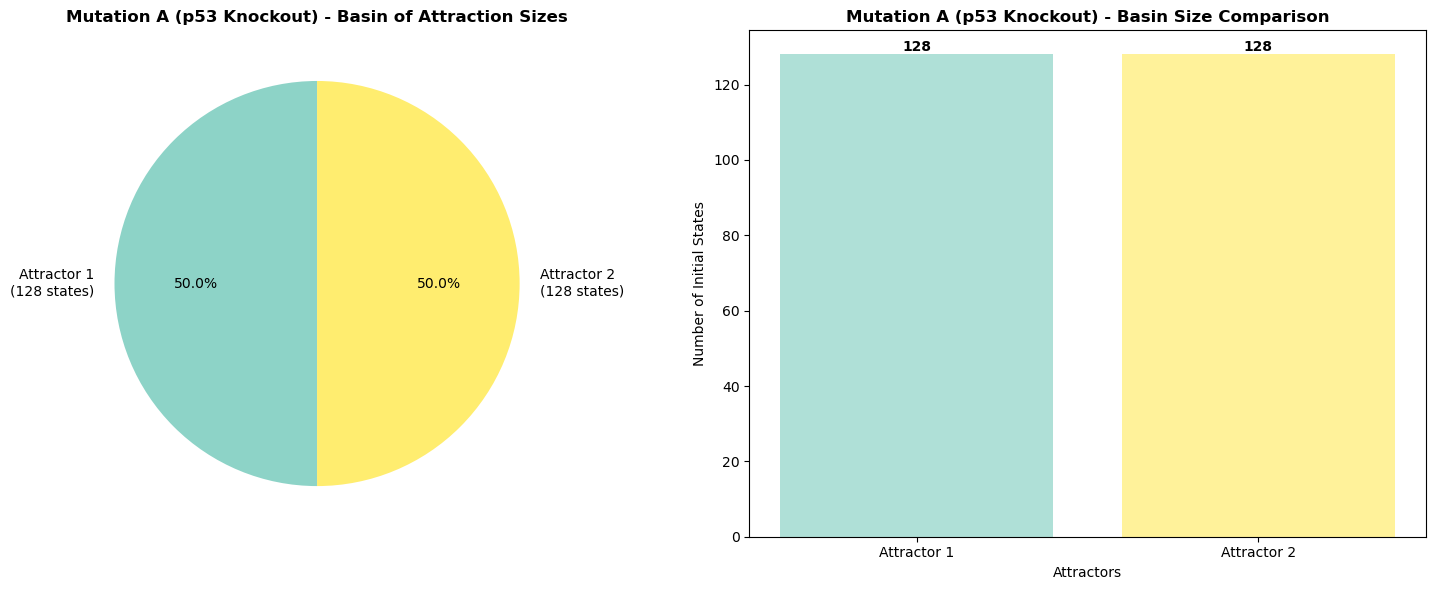

In [23]:
basin_analysis(p53_mutant, graph_title_a, mutant_attractors, mutant_attractor_info)

## Mutation B: MYC Amplification (Oncogene overexpression)
Now we mutate the Boolean network by forcing MYC permanently ON.
This mimics an oncogene amplification mutation frequently observed in cancers, where MYC is overexpressed due to gene amplification. As a result, the cell receives a constant “grow and divide” signal, even in the presence of DNA damage.



In [24]:
#  Apply Mutation
MYC_amplification = create_regulatory_network(MYC_amplification=True) 
print(f"{MYC_amplification.rules['MYC']['description']}")

MYC = AMPLIFIED (always ON)


### Scenario Analysis Under Mutation B

Reuse the three practical scenarios to check how the fate decision changes when `MYC` is permanently ON.

  Healthy Cell: Growth=1, Death=0, MYC=1
  Stressed Cell: Growth=1, Death=0, MYC=1
  Oncogene Hijacked Cell: Growth=1, Death=0, MYC=1


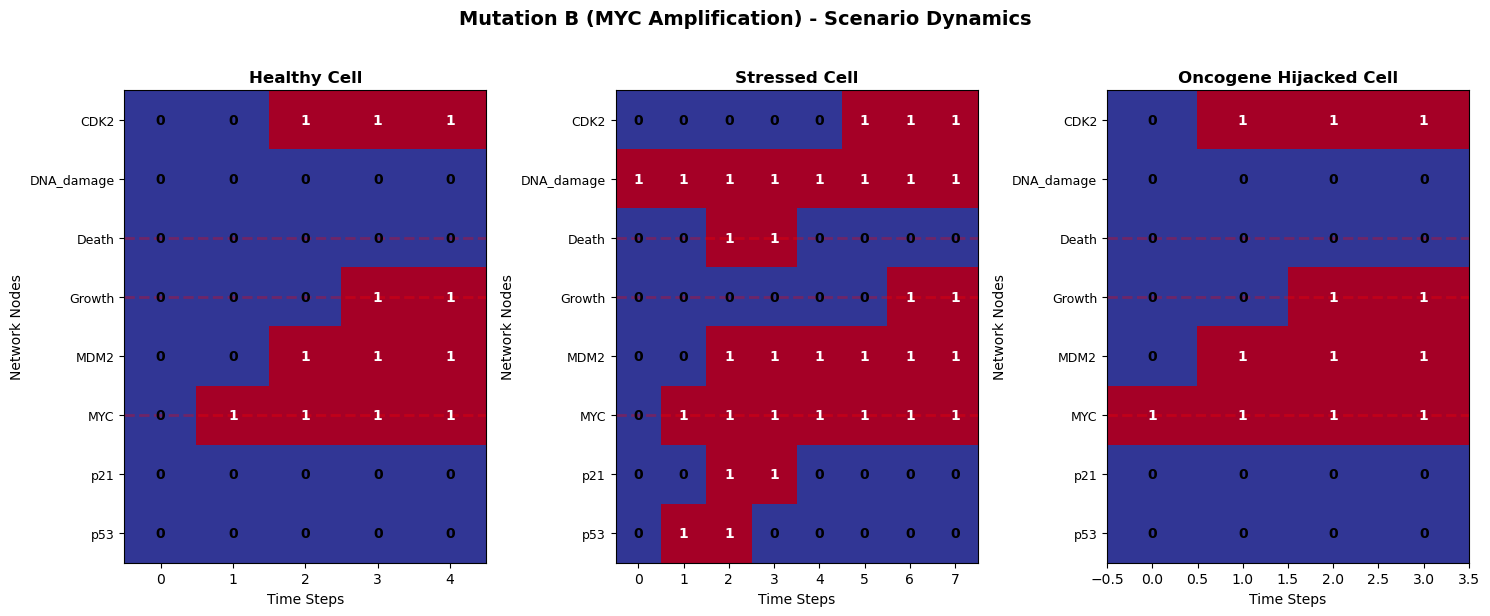

In [25]:
#  Scenario analysis with the MYC  Amplification
graph_title_b = 'Mutation B (MYC Amplification)'
scenario_analysis(MYC_amplification, graph_title_b, 'MYC')


### Attractor Analysis for Mutation B

Scan the full state space to see which steady states remain reachable and how often the network falls into cancer-like behaviour.

Testing all 256 possible initial states under Mutation of MYC

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | MYC: ON | DNA Damage: OFF
   Interpretation: Cancer-like growth in healthy conditions

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | MYC: ON | DNA Damage: ON
   Interpretation: Cancer-like growth despite DNA damage


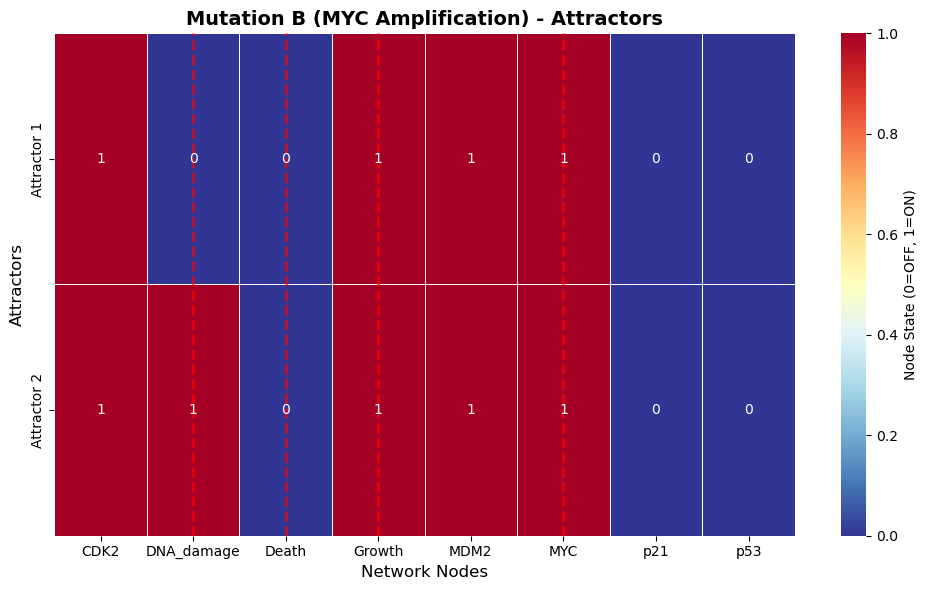

In [26]:
#  Attractor search for the myc amplification network
mutant_attractors, mutant_attractor_info = attractor_search(MYC_amplification, graph_title_b, 'MYC')


Basin sizes underMutation B (MYC Amplification):
  Attractor 1: 128 states ( 50.0%) -> Cancer-like growth in healthy conditions
  Attractor 2: 128 states ( 50.0%) -> Cancer-like growth despite DNA damage

Overall, 256 of 256 states (100.0%) flow into cancer-like attractors when p53 is knocked out.


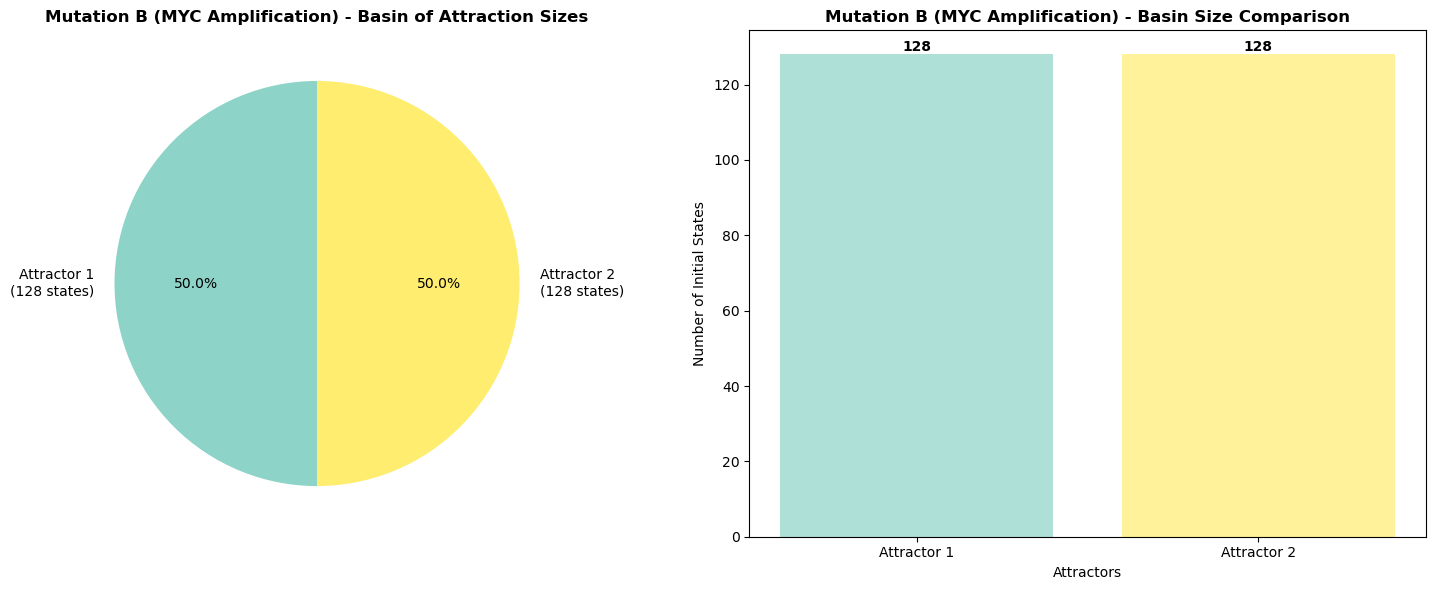

In [27]:
#  Basin analysis for Mutation B
basin_analysis(MYC_amplification, graph_title_b, mutant_attractors, mutant_attractor_info)

## Mutation C: MDM2 overexpression (p53 pathway disruption)
Now we mutate the Boolean network by making MDM2 overexpressed.

In [28]:
# Apply Mutation
MDM2_overexpression = create_regulatory_network(MDM2_overexpression=True) 
print(f"{MDM2_overexpression.rules['MDM2']['description']}")

MDM2 = OVEREXPRESSED (always ON)


### Scenario Analysis Under Mutation C

Reuse the three practical scenarios to check how the fate decision changes when `MDM2` is overexpressed.

  Healthy Cell: Growth=1, Death=0, MDM2=1
  Stressed Cell: Growth=1, Death=0, MDM2=1
  Oncogene Hijacked Cell: Growth=1, Death=0, MDM2=1


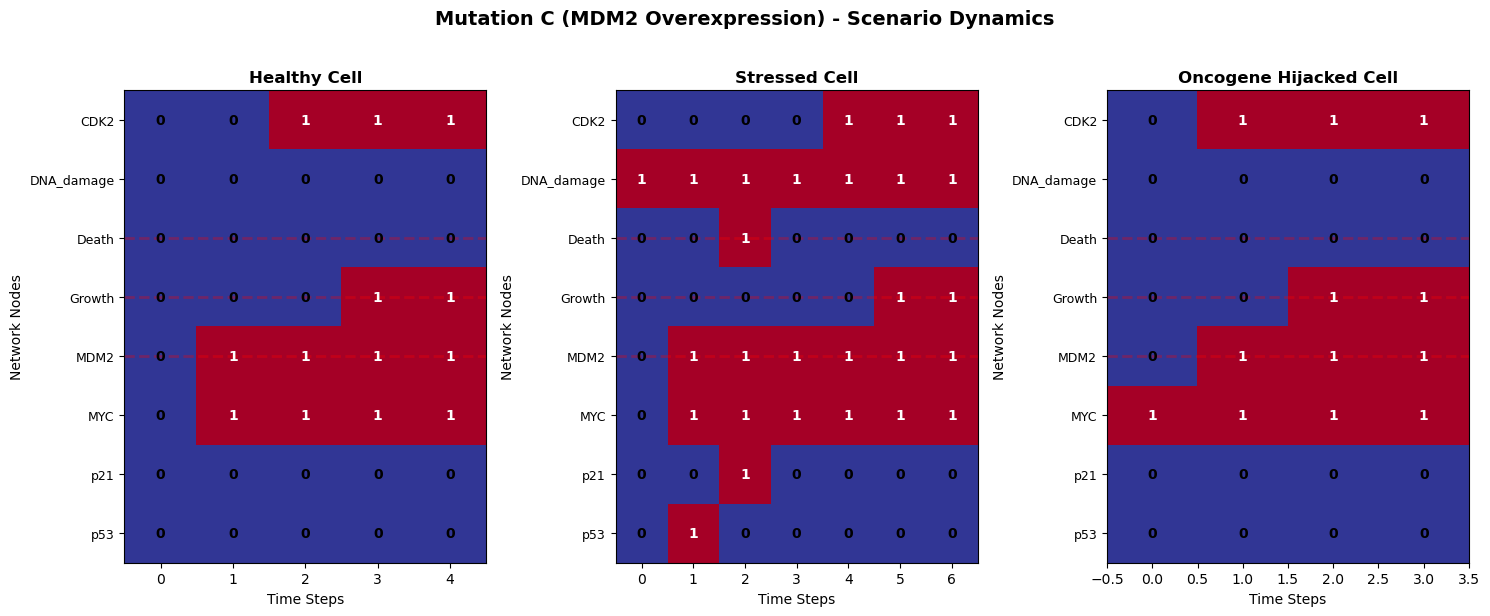

In [29]:
#  Scenario analysis with the MDM2 overexpression
graph_title_c = 'Mutation C (MDM2 Overexpression)'
scenario_analysis(MDM2_overexpression, graph_title_c, 'MDM2')

### Attractor Analysis for Mutation C

Scan the full state space to see which steady states remain reachable and how often the network falls into cancer-like behaviour.

Testing all 256 possible initial states under Mutation of MDM2

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | MDM2: ON | DNA Damage: OFF
   Interpretation: Cancer-like growth in healthy conditions

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON | Death: OFF | MDM2: ON | DNA Damage: ON
   Interpretation: Cancer-like growth despite DNA damage


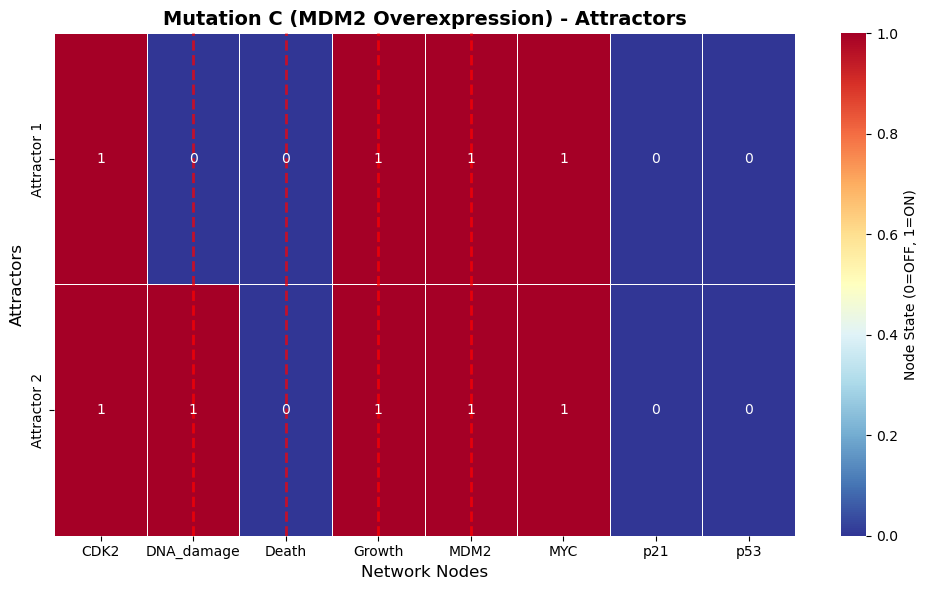

In [30]:
mutant_attractors, mutant_attractor_info = attractor_search(MDM2_overexpression, graph_title_c, 'MDM2')


Basin sizes underMutation C (MDM2 Overexpression):
  Attractor 1: 128 states ( 50.0%) -> Cancer-like growth in healthy conditions
  Attractor 2: 128 states ( 50.0%) -> Cancer-like growth despite DNA damage

Overall, 256 of 256 states (100.0%) flow into cancer-like attractors when p53 is knocked out.


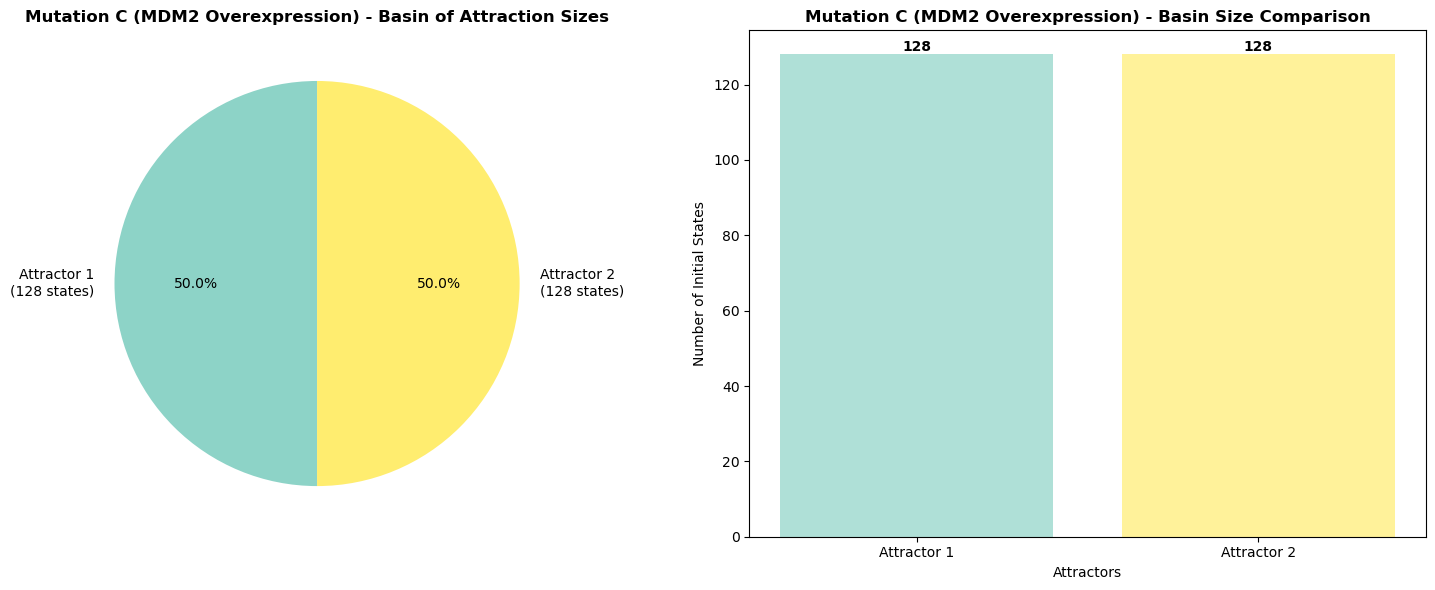

In [31]:
basin_analysis(MDM2_overexpression, graph_title_c, mutant_attractors, mutant_attractor_info)

## Mutation D(OUR CHOICE): CDK2 Knockout
Now we mutate the Boolean network by knocking out CDK2.(Tumour suppressor therapies aim to inactivate CDKs, expected effect would be that it blocks Growth regardless of MYC/p53 state)

In [42]:
## apply mutation
CDK2_mutant = create_regulatory_network(CDK2_knockout = True)
print(f"{CDK2_mutant.rules['CDK2']['description']}")

CDK2 = KNOCKOUT (always OFF)


### Scenario Analysis Under Mutation D

Reuse the three practical scenarios to check how the fate decision changes when we knokout CDK2

  Healthy Cell: Growth=0, Death=0, CDK2=0
  Stressed Cell: Growth=0, Death=0, CDK2=0
  Oncogene Hijacked Cell: Growth=0, Death=0, CDK2=0


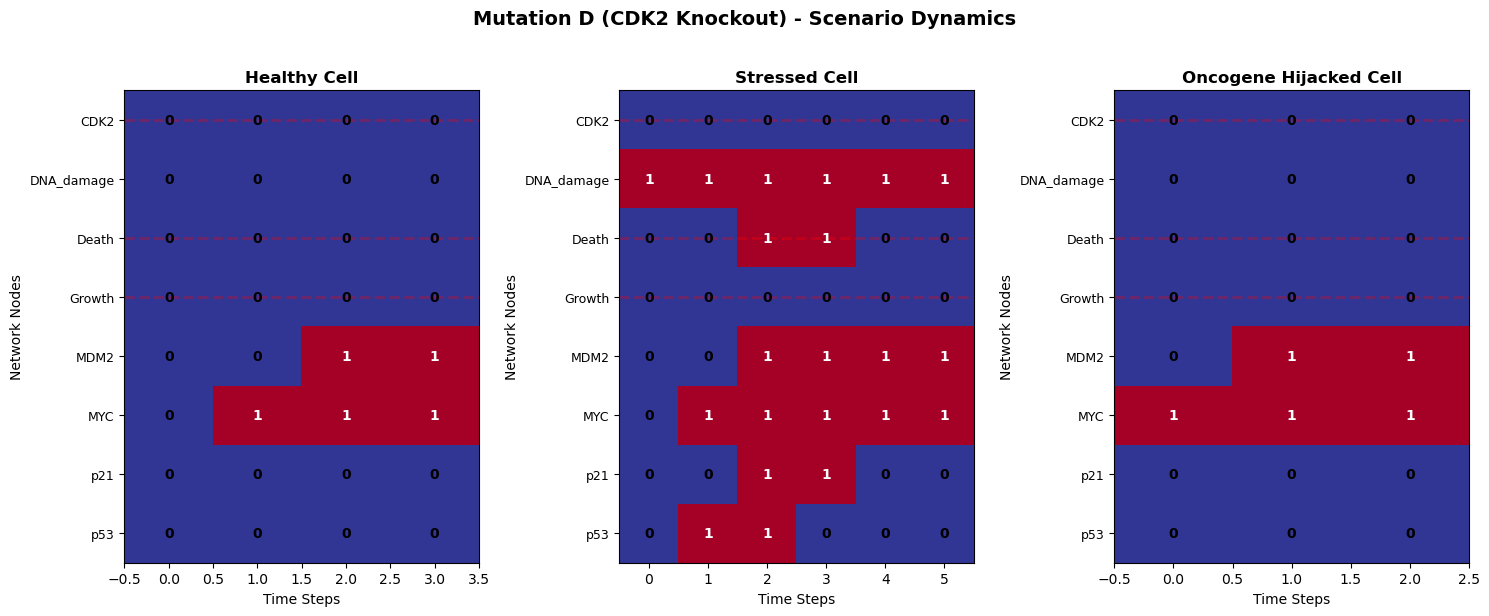

In [43]:
graph_title_d = 'Mutation D (CDK2 Knockout)'
scenario_analysis(CDK2_mutant, graph_title_d, 'CDK2')

### Attractor Analysis for Mutation D

Scan the full state space to see which steady states remain reachable and how often the network falls into cancer-like behaviour.

Testing all 256 possible initial states under Mutation of CDK2

Attractor 1: [0, 0, 0, 0, 1, 1, 0, 0]
   Growth: OFF | Death: OFF | CDK2: OFF | DNA Damage: OFF
   Interpretation: Quiescent or unresolved state

Attractor 2: [0, 1, 0, 0, 1, 1, 0, 0]
   Growth: OFF | Death: OFF | CDK2: OFF | DNA Damage: ON
   Interpretation: Quiescent or unresolved state


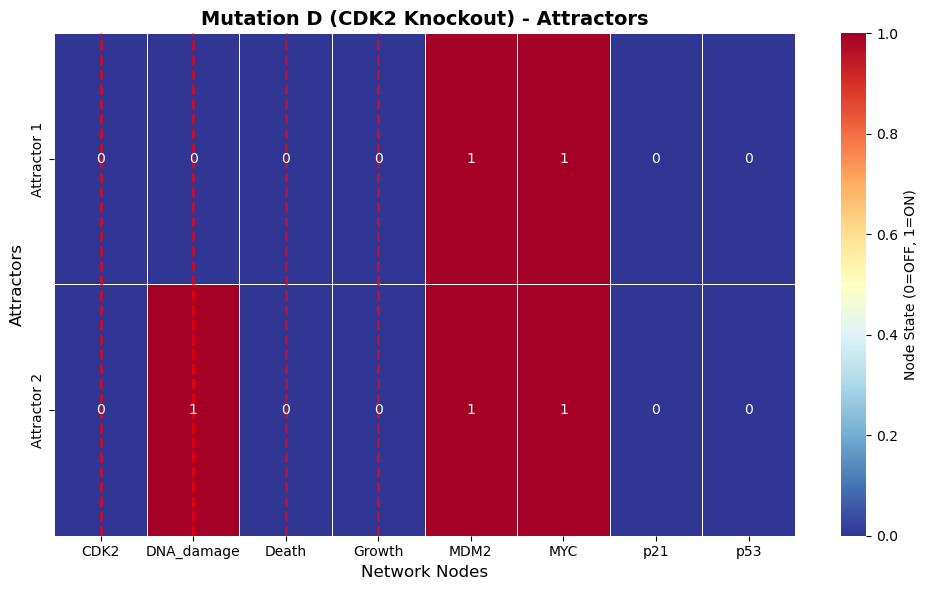

In [44]:
mutant_attractors, mutant_attractor_info = attractor_search(CDK2_mutant, graph_title_d, 'CDK2')


Basin sizes underMutation D (CDK2 Knockout):
  Attractor 1: 128 states ( 50.0%) -> Quiescent or unresolved state
  Attractor 2: 128 states ( 50.0%) -> Quiescent or unresolved state

Overall, 0 of 256 states (  0.0%) flow into cancer-like attractors when p53 is knocked out.


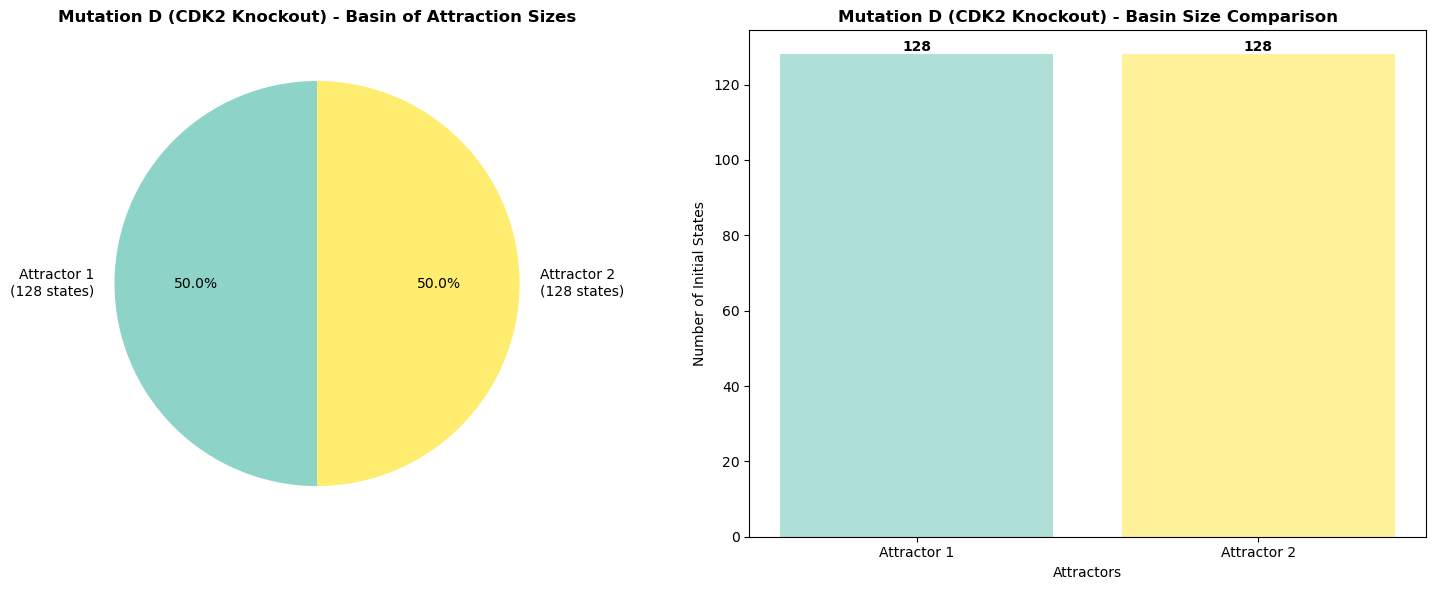

In [45]:
basin_analysis(CDK2_mutant, graph_title_d, mutant_attractors, mutant_attractor_info)